# Imports and Environment Setup

In [894]:
from __future__ import annotations

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm

import gymnasium as gym

env = gym.make("Blackjack-v1", sab=True)

# Building a Monte Carlo ES agent

In [895]:
class BlackjackMCES:
    def __init__(self, discount_factor: float = 0.95):
        self.discount_factor = discount_factor
        
        self.policy = defaultdict(lambda: int(np.random.randint(0, env.action_space.n)))
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))
        self.returns = defaultdict(lambda: np.zeros(env.action_space.n, dtype=int))
        
    def get_action(self, obs: tuple[int, int, bool]) -> int:
        return self.policy[obs]
    
    def monte_carlo(
        self,
        episode_pairs: list[tuple, int],
        episode_dict: dict,
    ):
        T = len(episode_pairs)
        g = 0
        for index in range(T-1, -1, -1):
            obs, action = episode_pairs[index]
            reward = episode_dict[obs][action]
            g = self.discount_factor * g + reward
            if (obs, action) not in episode_pairs[:index]:
                self.returns[obs][action] = self.returns[obs][action] + 1
                self.q_values[obs][action] = self.q_values[obs][action] + (g - self.q_values[obs][action]) / self.returns[obs][action]
                self.policy[obs] = int(np.argmax(self.q_values[obs]))

In [896]:
# hyperparameters
n_episodes = 500_000

agent = BlackjackMCES()

In [918]:
n_episodes = 100_000

In [919]:
env = gym.make("Blackjack-v1", sab=True)
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)

In [920]:
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False
    
    episode_pairs: list[tuple] = []
    episode_dict = defaultdict(dict)
    
    # play one episode
    while True:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        
        # caching episode (S_t, A_t, R_t+1)
        episode_pairs.append((obs, action))
        episode_dict[obs][action] = reward
        
        # when episode is terminated
        done = terminated or truncated
        obs = next_obs
        if done:
            agent.monte_carlo(episode_pairs, episode_dict)
            break

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:07<00:00, 12552.42it/s]


# Visualizing the training

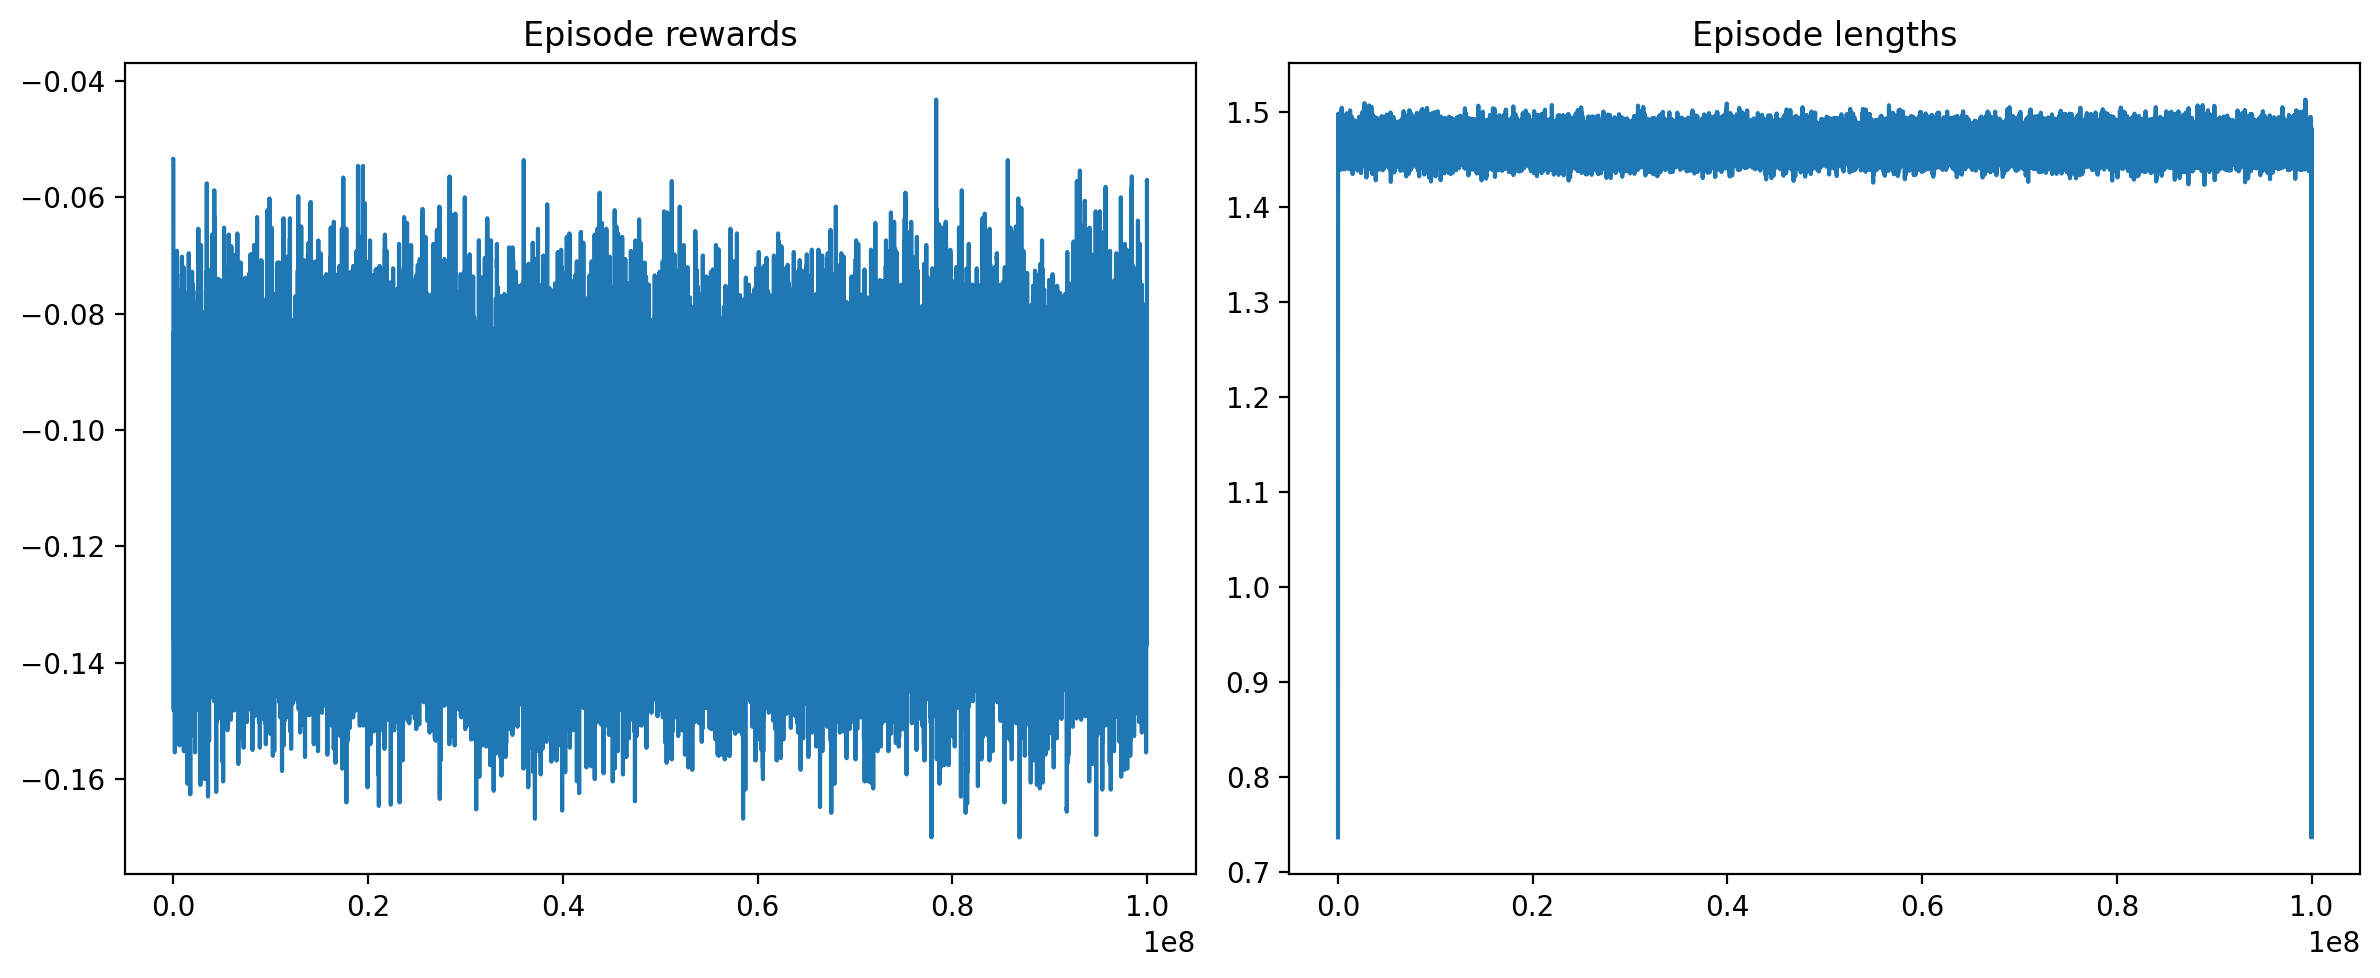

In [914]:
rolling_length = 5000
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
plt.tight_layout()
plt.show()

# Visualizing the policy

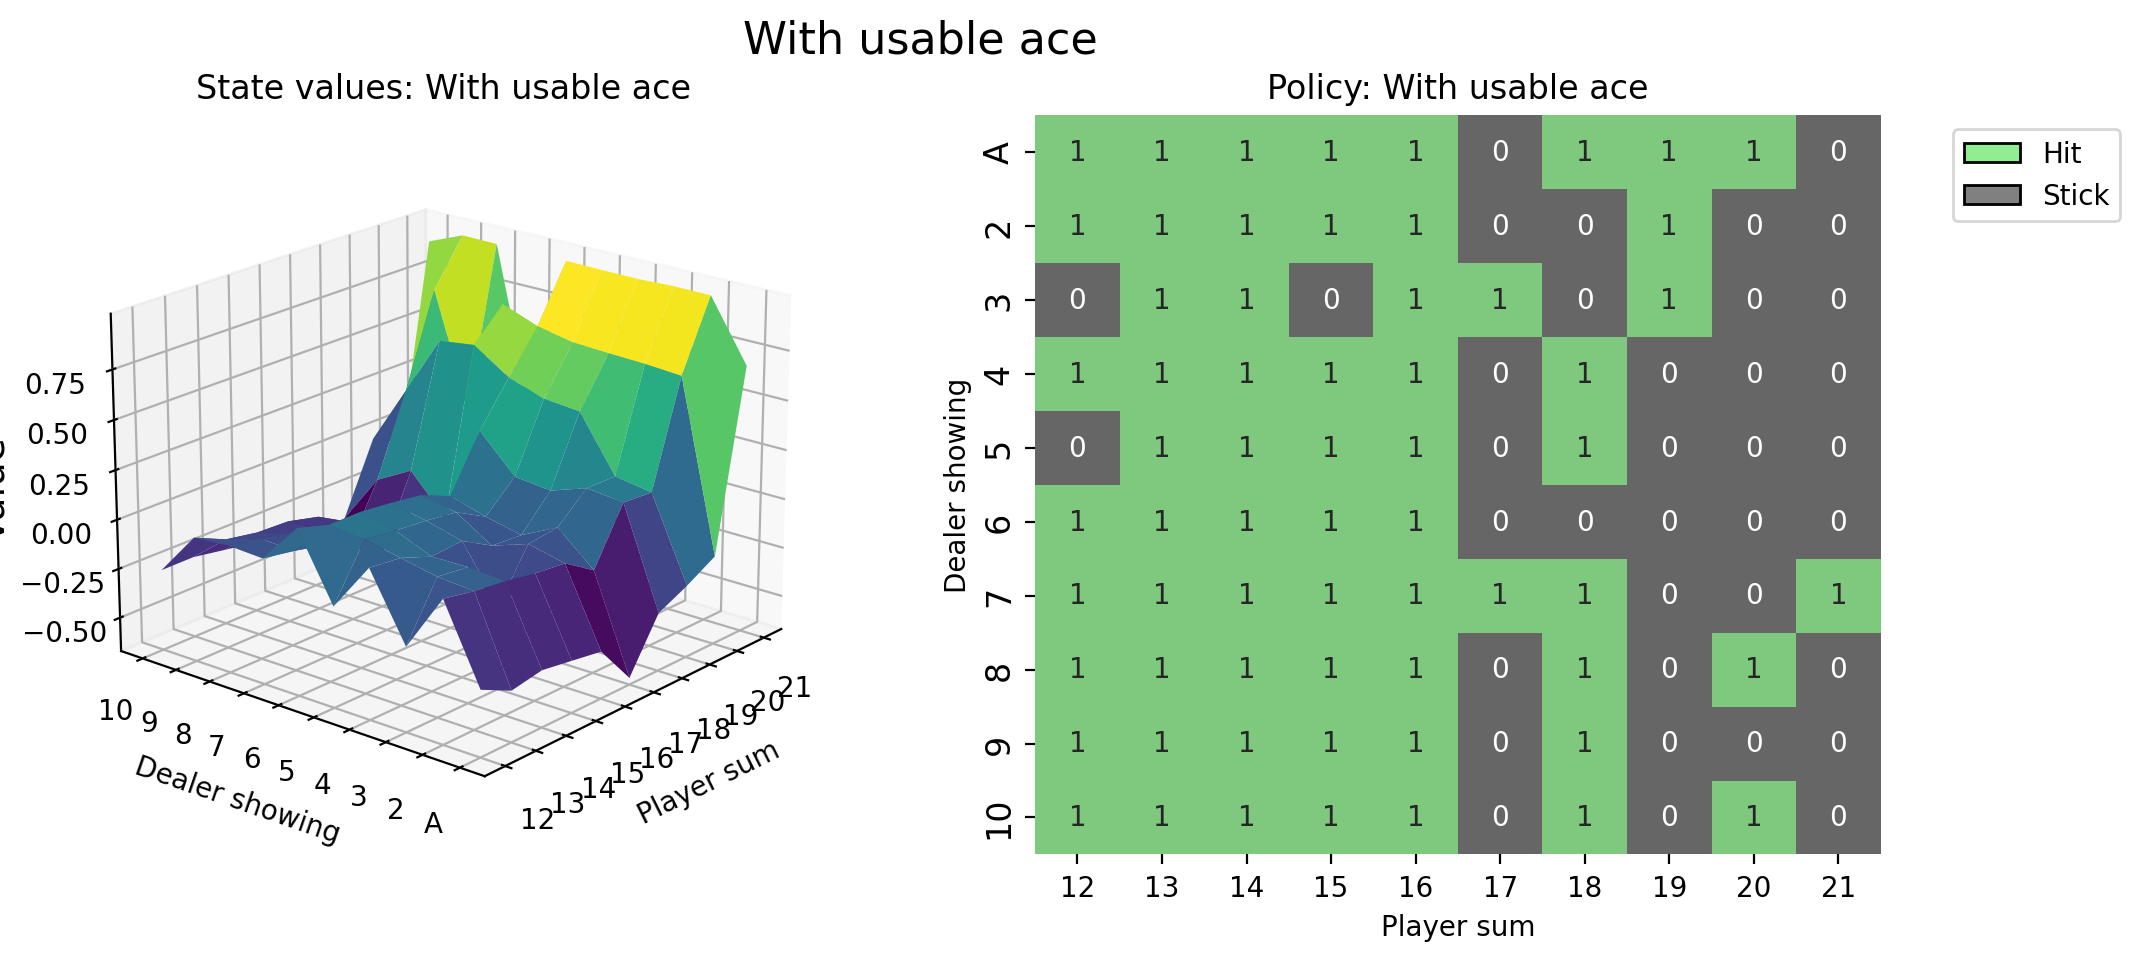

In [915]:
def create_grids(agent, usable_ace=False):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict(float)
    policy = agent.policy
    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))

    player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(12, 22),
        np.arange(1, 11),
    )

    # create the value grid for plotting
    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    value_grid = player_count, dealer_count, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return value_grid, policy_grid


def create_plots(value_grid, policy_grid, title: str):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    # add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig


# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

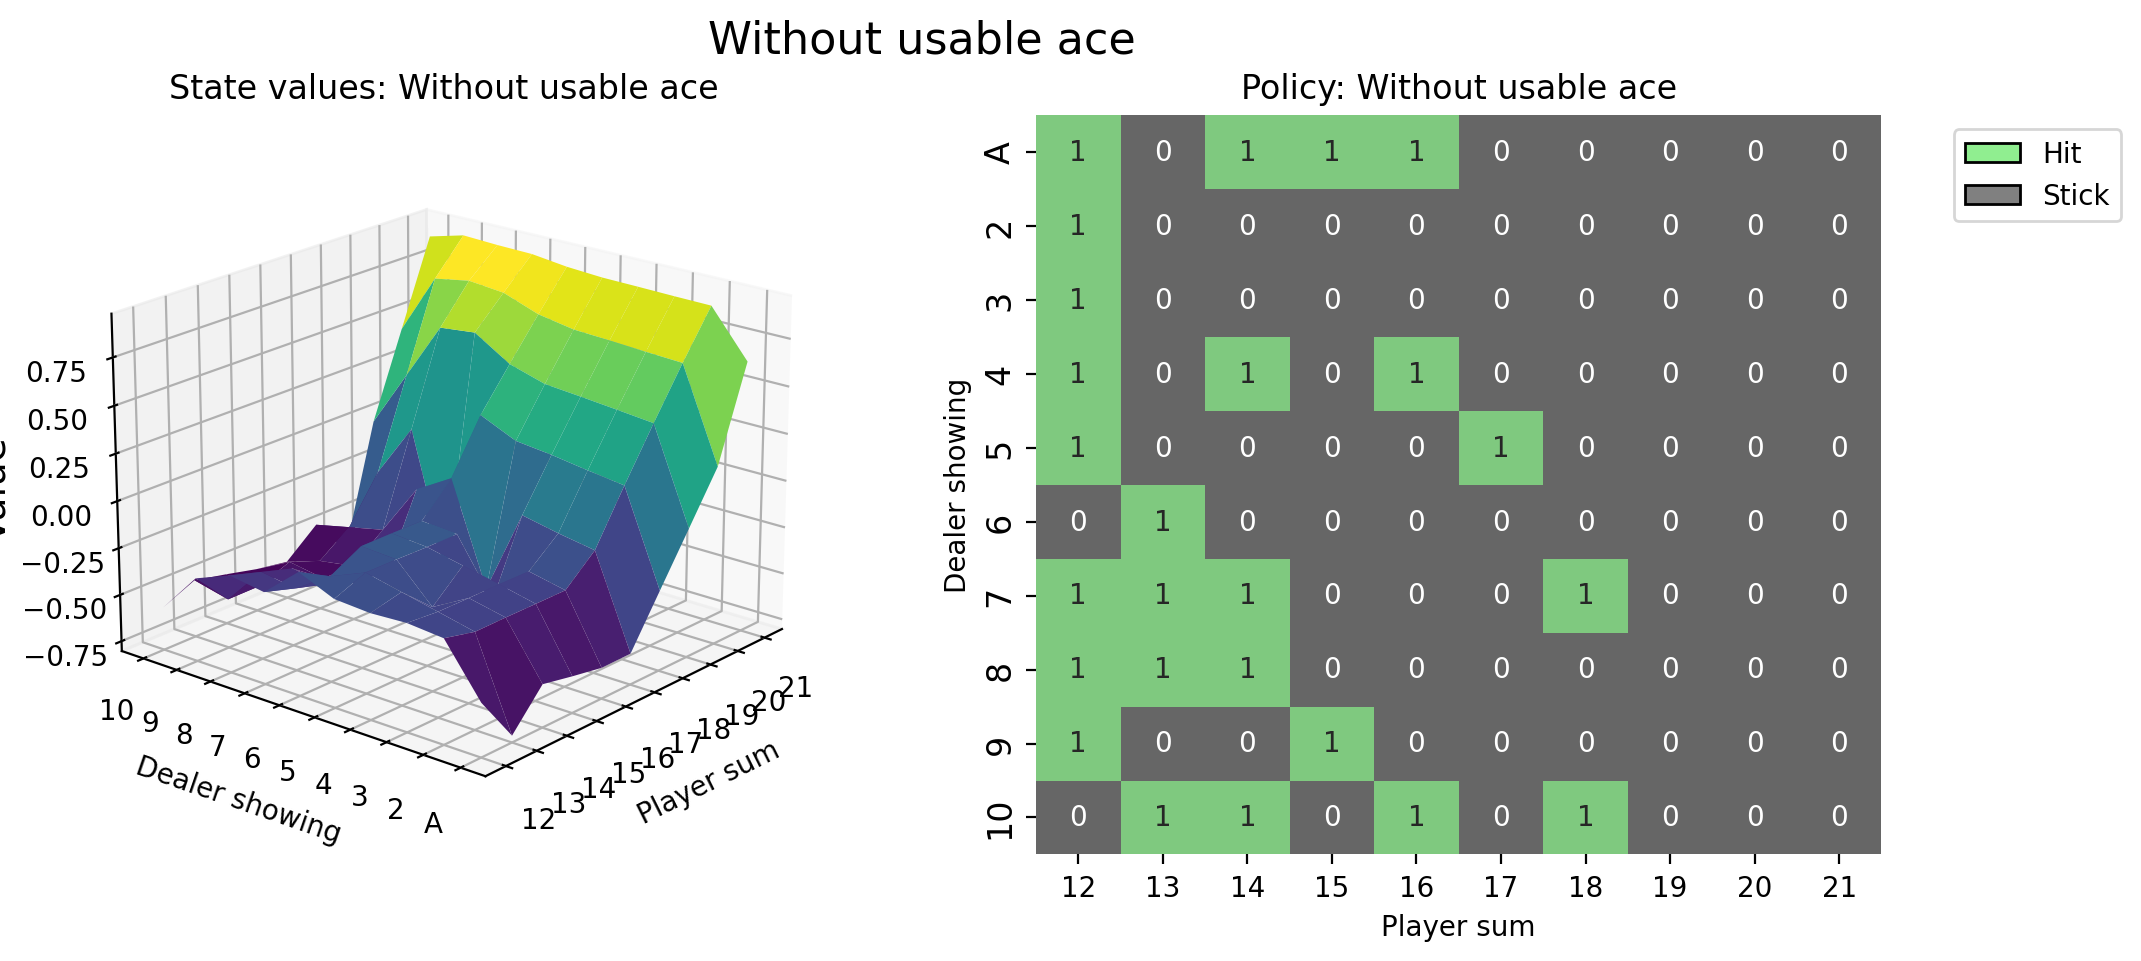

In [916]:
# state values & policy without usable ace (ace counts as 1)
value_grid, policy_grid = create_grids(agent, usable_ace=False)
fig2 = create_plots(value_grid, policy_grid, title="Without usable ace")
plt.show()

In [917]:
env.close()

---
# SARSA UPDATE

## Building a Sarsa agent

In [809]:
class BlackjackSarsa:
    def __init__(
        self, 
        step_size: float, 
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95
    ):
        self.step_size = step_size
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.discount_factor = discount_factor
        
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n, dtype=float))
        
        self.td_errors: list[float] = []
        
    def get_action(self, obs: tuple[int, int, bool]) -> int:
        if np.random.random() < self.epsilon:
            return env.action_space.sample()
        else:
            return int(np.argmax(self.q_values[obs]))
    
    def sarsa(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        next_obs: tuple[int, int, bool],
        next_action: int,
    ):
        q_value = self.q_values[obs][action]
        future_q_value = self.q_values[next_obs][next_action]
        
        td_error = reward + self.discount_factor * future_q_value - q_value
        self.q_values[obs][action] += self.step_size * td_error
        
        self.td_errors.append(td_error)
        
    def decay_epsilon(self):
        self.epsilon = max(self.epsilon - self.epsilon_decay, self.final_epsilon)

## Training

In [824]:
# hyperparameters
n_episodes = 300_000
step_size = 0.01
initial_epsilon = 1.1
epsilon_decay = 0.0
final_epsilon = 1.1

agent = BlackjackSarsa(step_size, epsilon, epsilon_decay, final_epsilon)

In [884]:
n_episodes = 10_000_000

In [885]:
env = gym.make("Blackjack-v1", sab=True)
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)

In [886]:
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    action = agent.get_action(obs)
    # play one episode
    while not done:
        next_obs, reward, terminated, truncated, info = env.step(action)
        next_action = agent.get_action(next_obs)
        agent.sarsa(obs, action, reward, next_obs, next_action)
        
        # when episode is terminated
        done = terminated or truncated
        obs = next_obs
        action = next_action  
    agent.decay_epsilon()

100%|████████████████████████████████████████████████████████████████████| 10000000/10000000 [13:26<00:00, 12402.23it/s]


# Visualizing the training

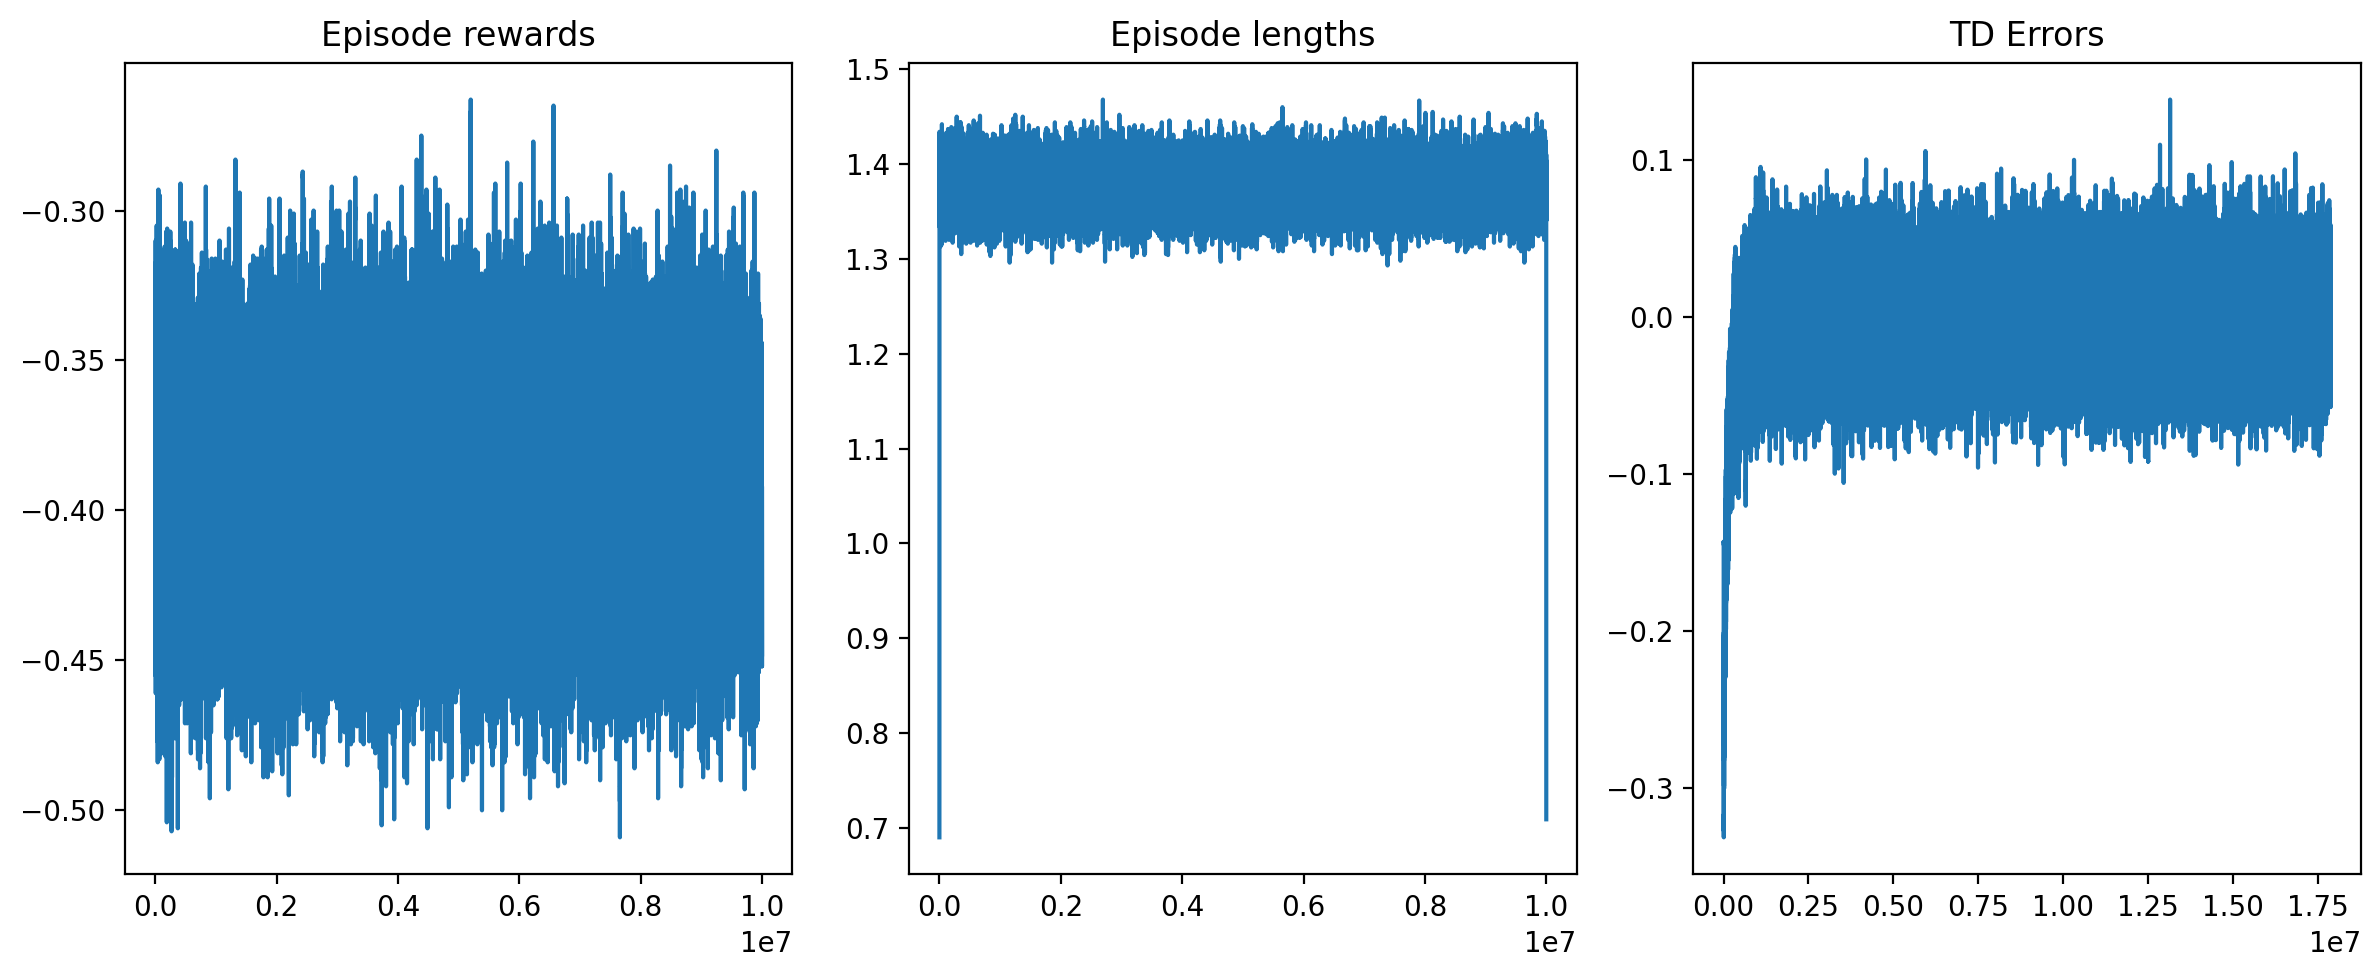

In [887]:
rolling_length = 1000
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))

axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)

axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)

axs[2].set_title("TD Errors")
td_error_moving_average = (
    np.convolve(
        np.array(agent.td_errors).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[2].plot(range(len(td_error_moving_average)), td_error_moving_average)

plt.tight_layout()
plt.show()

# Visualizing the policy

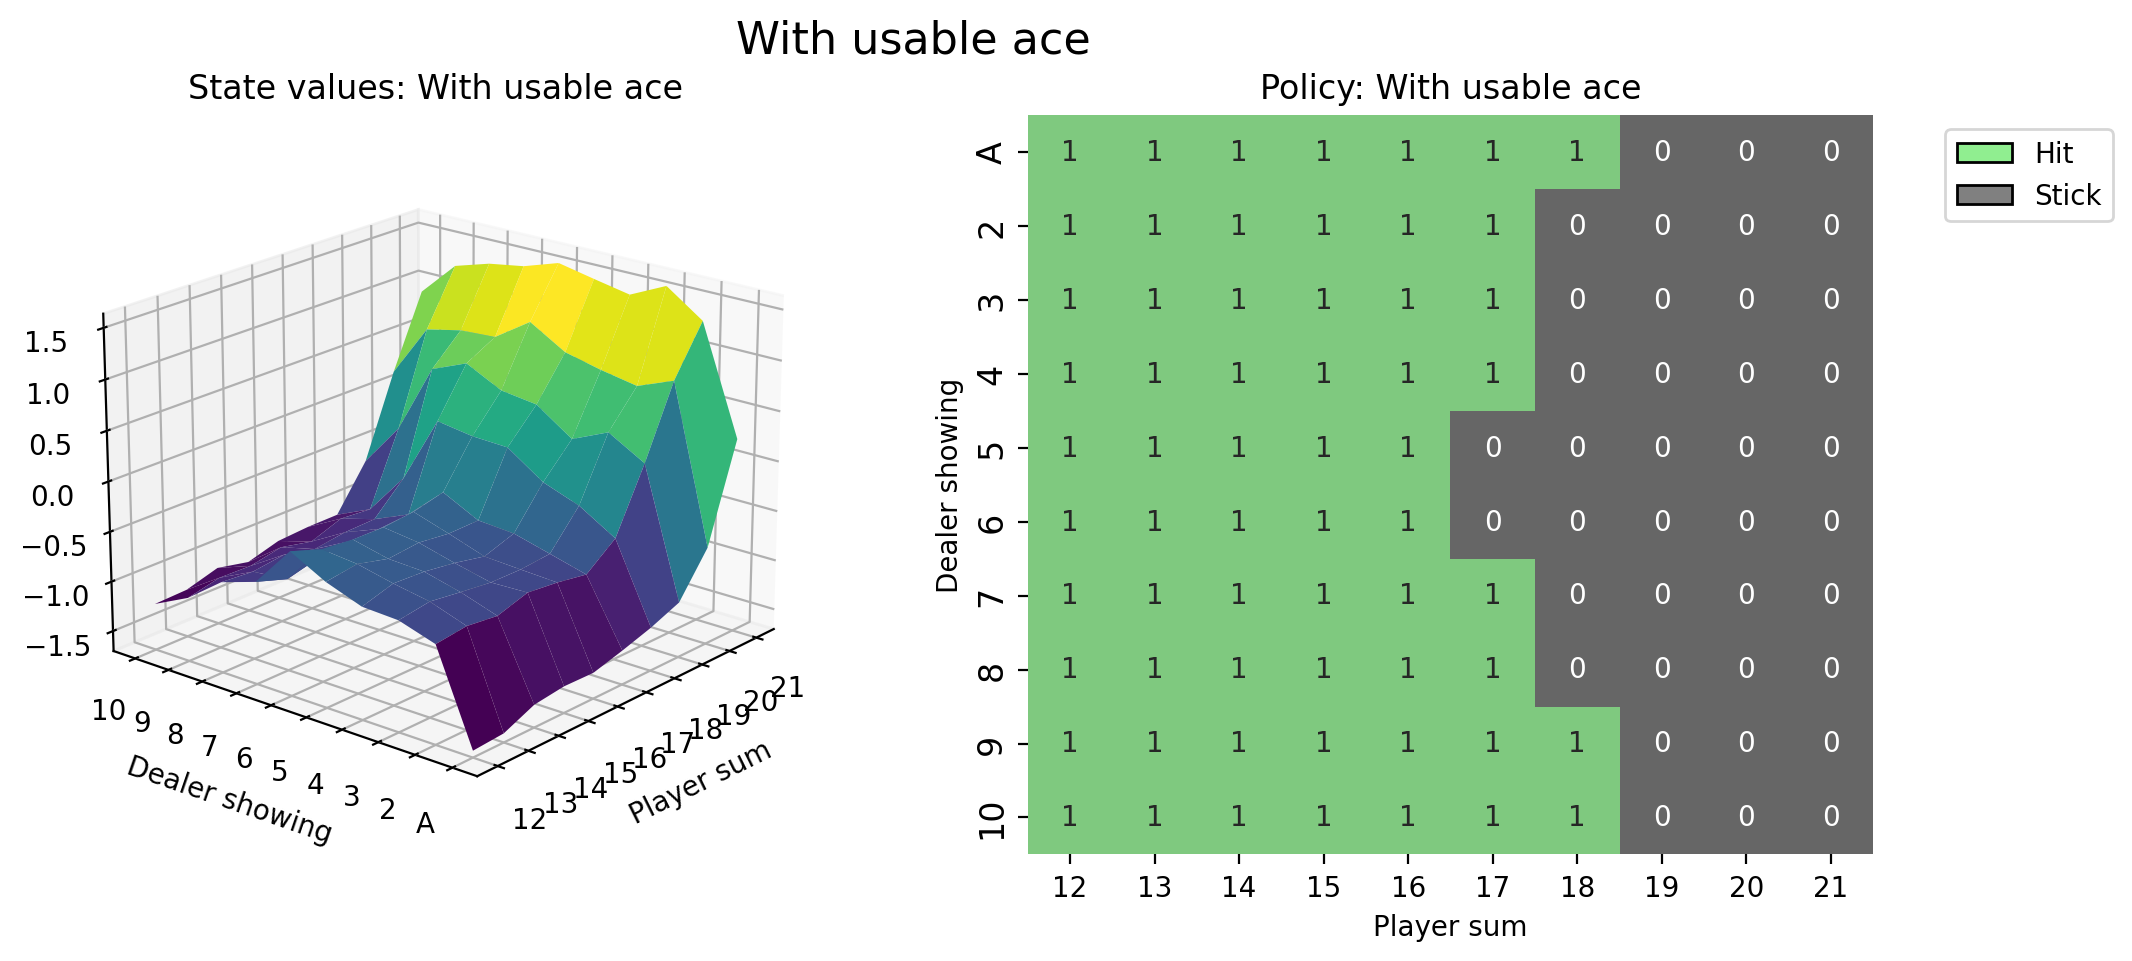

In [888]:
def create_grids(agent, usable_ace=False):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict(float)
    policy = defaultdict(float)
    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(12, 22),
        np.arange(1, 11),
    )

    # create the value grid for plotting
    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    value_grid = player_count, dealer_count, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return value_grid, policy_grid


def create_plots(value_grid, policy_grid, title: str):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    # add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig


# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

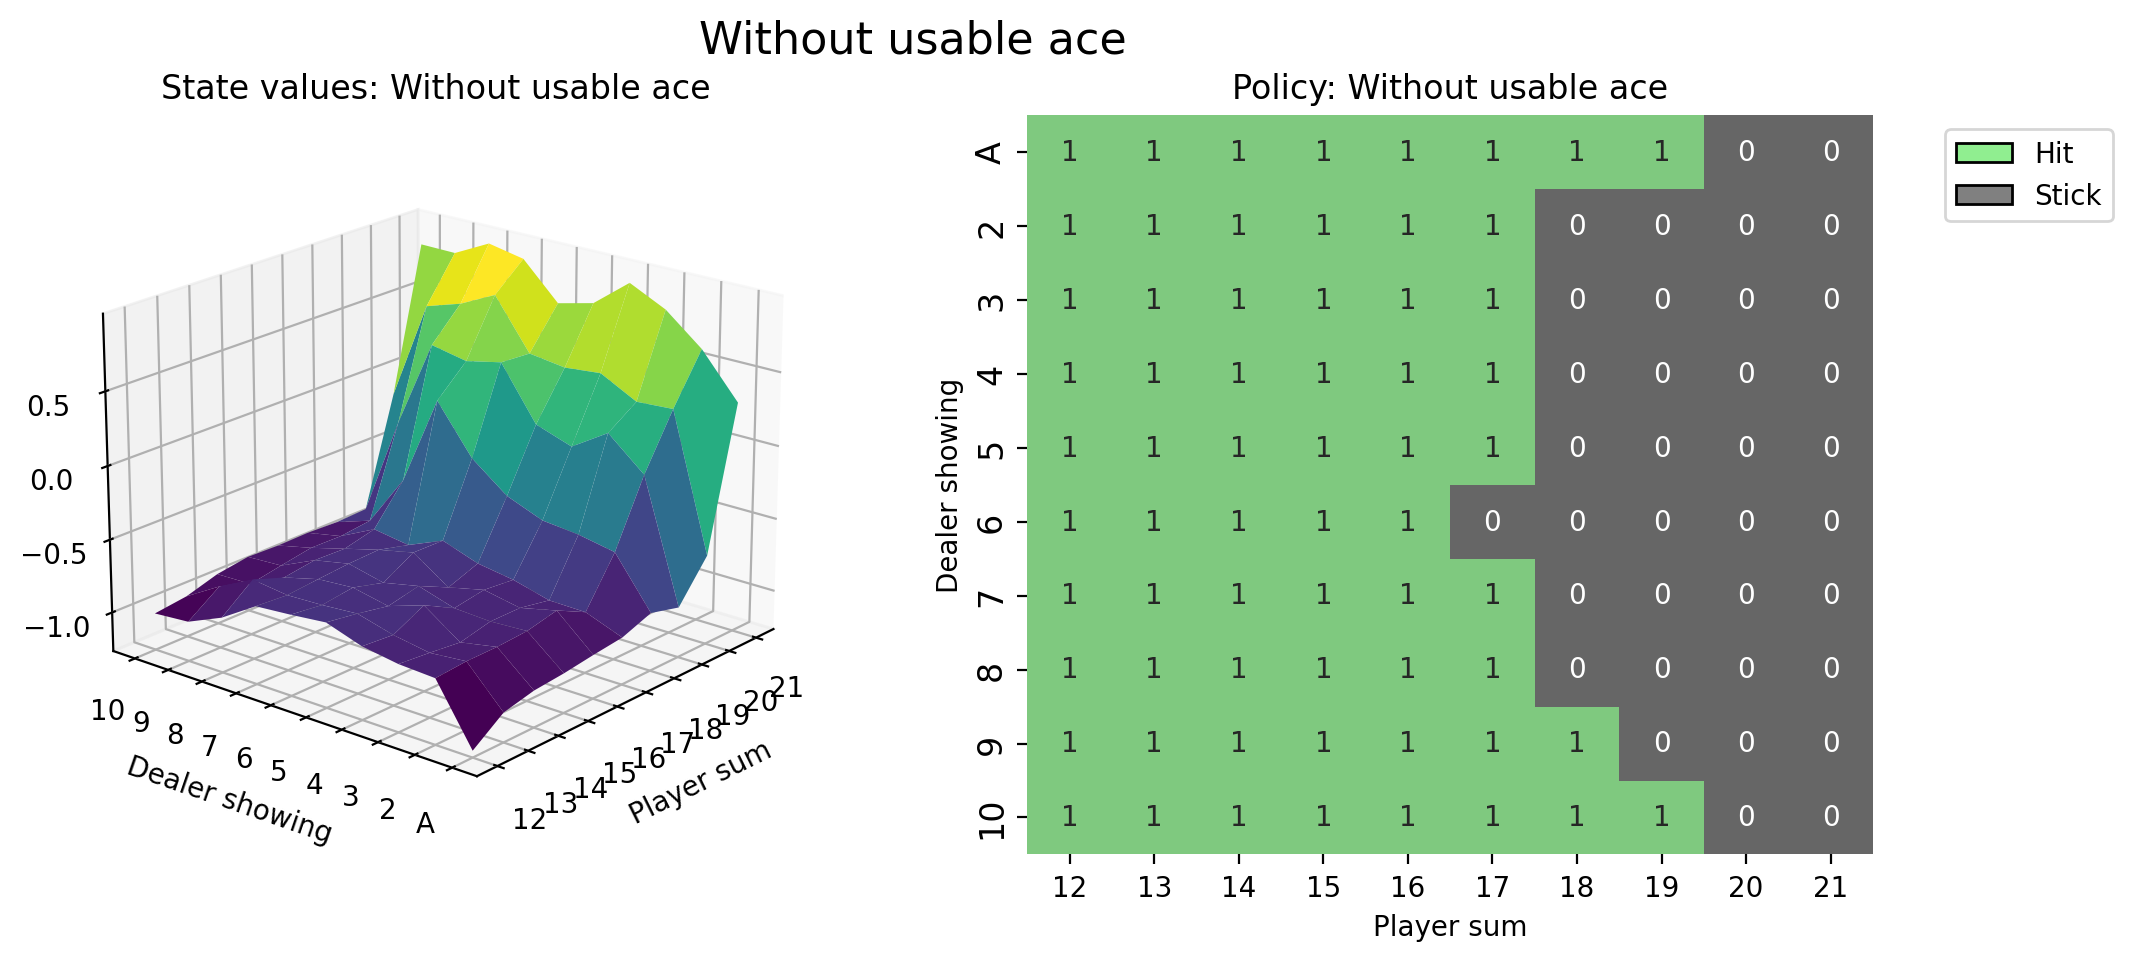

In [889]:
# state values & policy without usable ace (ace counts as 1)
value_grid, policy_grid = create_grids(agent, usable_ace=False)
fig2 = create_plots(value_grid, policy_grid, title="Without usable ace")
plt.show()

In [890]:
env.close()